<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 9 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 31 October 2022, with material by Thomas Wiecki</div>

# Hierarchies in Bayesian Sports Analytics

<br />
<center>
<img src="ipynb.images/long-jump.webp" width=1000 />
</center>

We saw examples of Sports Bayesian models

Let's do a simple one-dimensional **linear regression** problem with a single feature and a single target, modeled with Bayesian inference. 

There will be eight different groups, each with its own `slope`, and a fixed intercept of zero.

We will model each group by sampling slopes from a normal pdf with predefined mean and std, with some noise around a small intercept around 0.1

In [1]:
import numpy as np
np.random.seed(0) # to keep it reproducible
import pymc3 as pm
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
mean_slope = 2 # the 8 different slopes have a mean of 2
slopes = np.random.normal(mean_slope, size=8)

groups = np.array(50*[0, 1, 2, 3, 4, 5, 6] + 5*[7])

x = np.random.randn(355)
y = slopes[groups] * x + 0.1*np.random.randn(355)

In [3]:
slopes

array([3.76405235, 2.40015721, 2.97873798, 4.2408932 , 3.86755799,
       1.02272212, 2.95008842, 1.84864279])

In [4]:
groups

array([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
       1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
       2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
       3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3,
       4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
       5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5,
       6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6,
       0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
       1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
       2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
       3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3,
       4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
       5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5,
       6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6,

In [5]:
x

array([-0.10321885,  0.4105985 ,  0.14404357,  1.45427351,  0.76103773,
        0.12167502,  0.44386323,  0.33367433,  1.49407907, -0.20515826,
        0.3130677 , -0.85409574, -2.55298982,  0.6536186 ,  0.8644362 ,
       -0.74216502,  2.26975462, -1.45436567,  0.04575852, -0.18718385,
        1.53277921,  1.46935877,  0.15494743,  0.37816252, -0.88778575,
       -1.98079647, -0.34791215,  0.15634897,  1.23029068,  1.20237985,
       -0.38732682, -0.30230275, -1.04855297, -1.42001794, -1.70627019,
        1.9507754 , -0.50965218, -0.4380743 , -1.25279536,  0.77749036,
       -1.61389785, -0.21274028, -0.89546656,  0.3869025 , -0.51080514,
       -1.18063218, -0.02818223,  0.42833187,  0.06651722,  0.3024719 ,
       -0.63432209, -0.36274117, -0.67246045, -0.35955316, -0.81314628,
       -1.7262826 ,  0.17742614, -0.40178094, -1.63019835,  0.46278226,
       -0.90729836,  0.0519454 ,  0.72909056,  0.12898291,  1.13940068,
       -1.23482582,  0.40234164, -0.68481009, -0.87079715, -0.57

In [6]:
y

array([-3.54524663e-01,  9.83932743e-01,  4.45160874e-01,  6.14835328e+00,
        2.90387258e+00,  9.76663771e-02,  1.19663465e+00,  1.28401181e+00,
        3.48671230e+00, -5.26949587e-01,  1.30274083e+00, -3.29831530e+00,
       -2.56161548e+00,  1.99256409e+00,  3.09672076e+00, -1.80200309e+00,
        6.84902220e+00, -6.33762008e+00,  2.15701767e-01, -4.16993487e-01,
        4.41958352e+00,  5.53460638e+00,  2.06226670e-01,  1.02789599e+00,
       -3.91218804e+00, -7.49603171e+00, -3.39394675e-01,  5.17972311e-01,
        4.60861101e+00,  2.85055749e+00, -1.31539252e+00, -1.31121742e+00,
       -4.13148862e+00, -1.36649136e+00, -4.91953774e+00,  7.48947857e+00,
       -1.13799016e+00, -1.36477396e+00, -5.42456102e+00,  3.08365536e+00,
       -1.61493975e+00, -8.04456482e-01, -3.33503483e+00,  1.01007880e+00,
       -1.51566211e+00, -5.02544037e+00, -1.89761251e-01,  2.93411009e-01,
        2.76261482e-01,  1.10760861e+00, -1.54581941e+00, -9.07238771e-01,
       -2.78338283e+00, -

The groups variable contains the group each observation belongs to. There are fifty observations each for the groups 0 to 6. Then, there is the minority group number 7 at the end, with only five observations.

As a small guide, to get the elements belonging to group 2, you can use:

In [75]:
groups==2

array([False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,

In [76]:
x[groups==2], y[groups==2]

(array([-2.53021938,  0.09130393, -0.11785865,  0.79717306, -0.39931536,
        -0.73748766,  0.27199452,  0.58056933, -1.18296336, -0.19637542,
        -0.61989791, -0.11034687,  0.92558655,  0.02205313, -0.72654623,
         0.95199309,  0.05492747, -0.34036215, -0.35708002,  1.04161706,
         0.47979975,  0.9962308 ,  1.60464405,  3.04807701, -1.14967661,
        -1.4253105 , -1.25927957, -1.08567217,  1.12869507, -0.79541412,
        -1.28240608,  0.4932568 , -1.50663108, -0.58055169, -1.22547465,
        -0.42004466, -0.45402693,  0.787617  ,  0.32730673, -0.91546193,
         0.70155394,  0.55461901, -0.33413795, -1.37400597, -0.53694648,
         1.73962876,  1.07445929,  0.10122764,  0.245824  , -0.90501741]),
 array([-0.60442154,  0.09724633,  0.01804699,  0.28413164, -0.00229603,
        -0.13373187,  0.22570743,  0.33049762, -0.16912821, -0.01950049,
        -0.12929066,  0.05085987,  0.3189837 ,  0.20944216,  0.05859064,
         0.10769688,  0.10461724,  0.03355556,  0

The slope of this sub-dataset is 

In [7]:
slopes[2]

2.9787379841057393

To add complexity, let us add **outliers** to our minority group 7. Note that the last 5 observations are from minority group 7

In [8]:
y[-1] = 100
y[-2] = 100

In [79]:
y

array([ 1.75091744e+00, -9.31176022e-01, -6.04421541e-01, -2.75412789e+00,
       -1.10639190e+00, -3.03710582e+00,  4.20962489e-01, -5.07150148e-01,
        1.32403067e+00,  9.72463262e-02,  3.34132485e+00,  2.79093822e-01,
        3.16862708e-01, -1.15863765e+00, -8.22267561e-01, -3.05466120e-01,
        1.80469854e-02,  3.33219785e+00, -5.04163754e-01, -1.59033169e-01,
       -1.94665976e+00,  1.00524770e+00, -5.20677559e-01,  2.84131642e-01,
       -5.03676864e+00,  1.03663457e+00, -1.67725848e+00, -2.75562679e+00,
       -1.35967903e+00,  4.06608663e-01, -2.29603025e-03, -2.04121282e+00,
       -9.29428245e-01, -1.06976125e-01, -3.59391365e+00, -8.24202127e-02,
        7.13559205e-01, -1.33731865e-01, -2.94580670e+00, -1.81395580e-01,
       -1.22913997e-01,  2.74761691e+00, -6.70869127e-01, -1.94480348e+00,
        2.25707425e-01,  4.01854430e+00,  3.01111013e-01, -1.71385834e+00,
        5.42648896e-01, -4.12527621e-01,  3.94890531e+00,  3.30497619e-01,
        5.41895061e+00,  

# A Pooled Model
Let's ignore the groups and treat this dataset as one big block. 

A simple Bayesian linear regression without intercept, with the slope modelled as a normal with mean 0 and std 20 and the standard deviation as low-magnitude exponential noise:

In [9]:
with pm.Model() as pooled_model:
    slope = pm.Normal('slope', 0, 20) #mean 0 sd 20 (assumed)
    noise = pm.Exponential('noise', 0.1)
    
    obs = pm.Normal('obs', slope*x, noise, observed=y) #mu is slope
    
    pooled_trace = pm.sample(cores=1)

C:\Users\HP\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\HP\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\HP\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\HP\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [noise, slope]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 460 seconds.


Our model parameters posteriors look like:

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'slope'}>

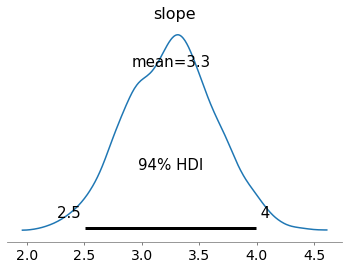

In [10]:
az.plot_posterior(pooled_trace, var_names=['slope'])

The problem with this model is that its not very informative: It groups all groups together and tells us that the mean slops is not 0, like we thought with our prior, but 2.2 instead.

That makes sense because we generated our data from a gaussian with a mean of 2!

# Unpoooled Model
The next thing to do is to model one slope *per group*:

In [82]:
with pm.Model() as unpooled_model:
    slope = pm.Normal('slope', 0, 20, shape=8) #assuming 8 diff groups
    noise = pm.Exponential('noise', 10)
    
    obs = pm.Normal('obs', slope[groups]*x, noise, observed=y)
    
    unpooled_trace = pm.sample(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [noise, slope]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:08<00:00, 114.14it/s]
The acceptance probability does not match the target. It is 0.909697567836625, but should be close to 0.8. Try to increase the number of tuning steps.


d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B0D7FDAAC8>,
      dtype=object)

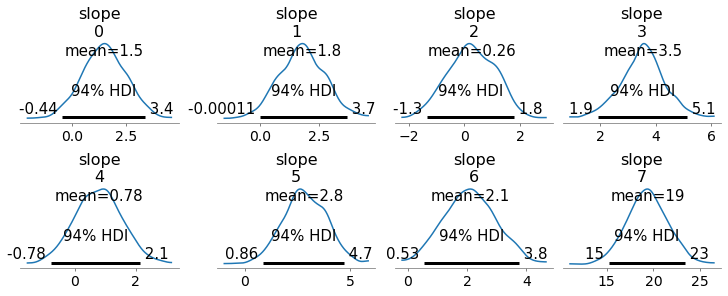

In [83]:
az.plot_posterior(unpooled_trace, var_names=['slope'], figsize=(10,4))

We get eight different slopes now that were trained independently!

We can also plot only the 94% high-density intervals (HDI), i.e. short credible intervals containing 94% of the posterior mass in a single figure):

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B0D4FF1630>],
      dtype=object)

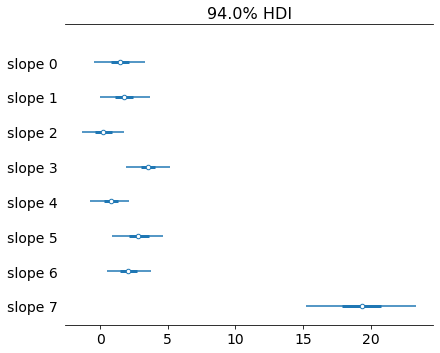

In [84]:
az.plot_forest(unpooled_trace, var_names=['slope'], combined=True)

You can see how groups 0 to 6 have small slopes, and group 7 is way out there. 

Wait, shouldn't our slopes be around a value of two? 

Yes but... we tricked the model by introducing outliers to the smallest group!

The sub-model for group 7 has no chance, as it does not know what is going on in groups 0 to 6! It has no clue about the slopes usually being around a value of two.

So, let's fix the problem!

# Partially pooled a.k.a. hierarchical model
In the unpooled model, we made up priors for the slopes via `slope = pm.Normal('slope', 0, 20, shape=8)`, with `shape=8` telling pymc3 to create a container of 8 slope variables.

We told the model that the slopes should be around zero, but with a quite large standard deviation of 20.

In a hierarchical model, we define so-called **hyperpriors** to find a better mean and standard deviation for the slope priors. 

Instead of:
```
slope = pm.Normal('slope', 0, 20, shape=8)
```

We do:
```
slope = pm.Normal('slope', mu_slope, sigma_slope, shape=8)
```

with:
```
mu_slope = pm.Normal('mu_slope', 0, 1) # hyperprior 1
sigma_slope = pm.Exponential('sigma_slope', 13) # hyperprior 2
```

In [89]:
with pm.Model() as hierarchical_model:
    mu_slope = pm.Normal('mu_slope', 0, 1) # hyperprior 1
    sigma_slope = pm.Exponential('sigma_slope', 13) # hyperprior 2
    
    slope = pm.Normal('slope', mu_slope, sigma_slope, shape=8)
    noise = pm.Exponential('noise', 10)
    
    obs = pm.Normal('obs', slope[groups]*x, noise, observed=y)
    
    # taget_accept reduces the risk of divergences
    hierarchical_trace = pm.sample(
        target_accept=0.995, cores=1
    )
    # A few divergences here...
    #hierarchical_trace = pm.sample(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [noise, slope, sigma_slope, mu_slope]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Whereas in our unpooled model we had a normal data likelihood with two parameters modeled as pdfs, we now have a normal data likelihood with two parameter pdfs whose parameters are themselves pdfs!

Specifically, the mean is a normal distribution centered at 0 with a standard deviation of 1, and the slope is an exponential distribution with a decay rate of 13.

This model is much more complex and takes more time to sample from and converge. But it does converge pretty nicely with no divergences.

d:\Anaconda3.5.1\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B0DEE31DA0>,
      dtype=object)

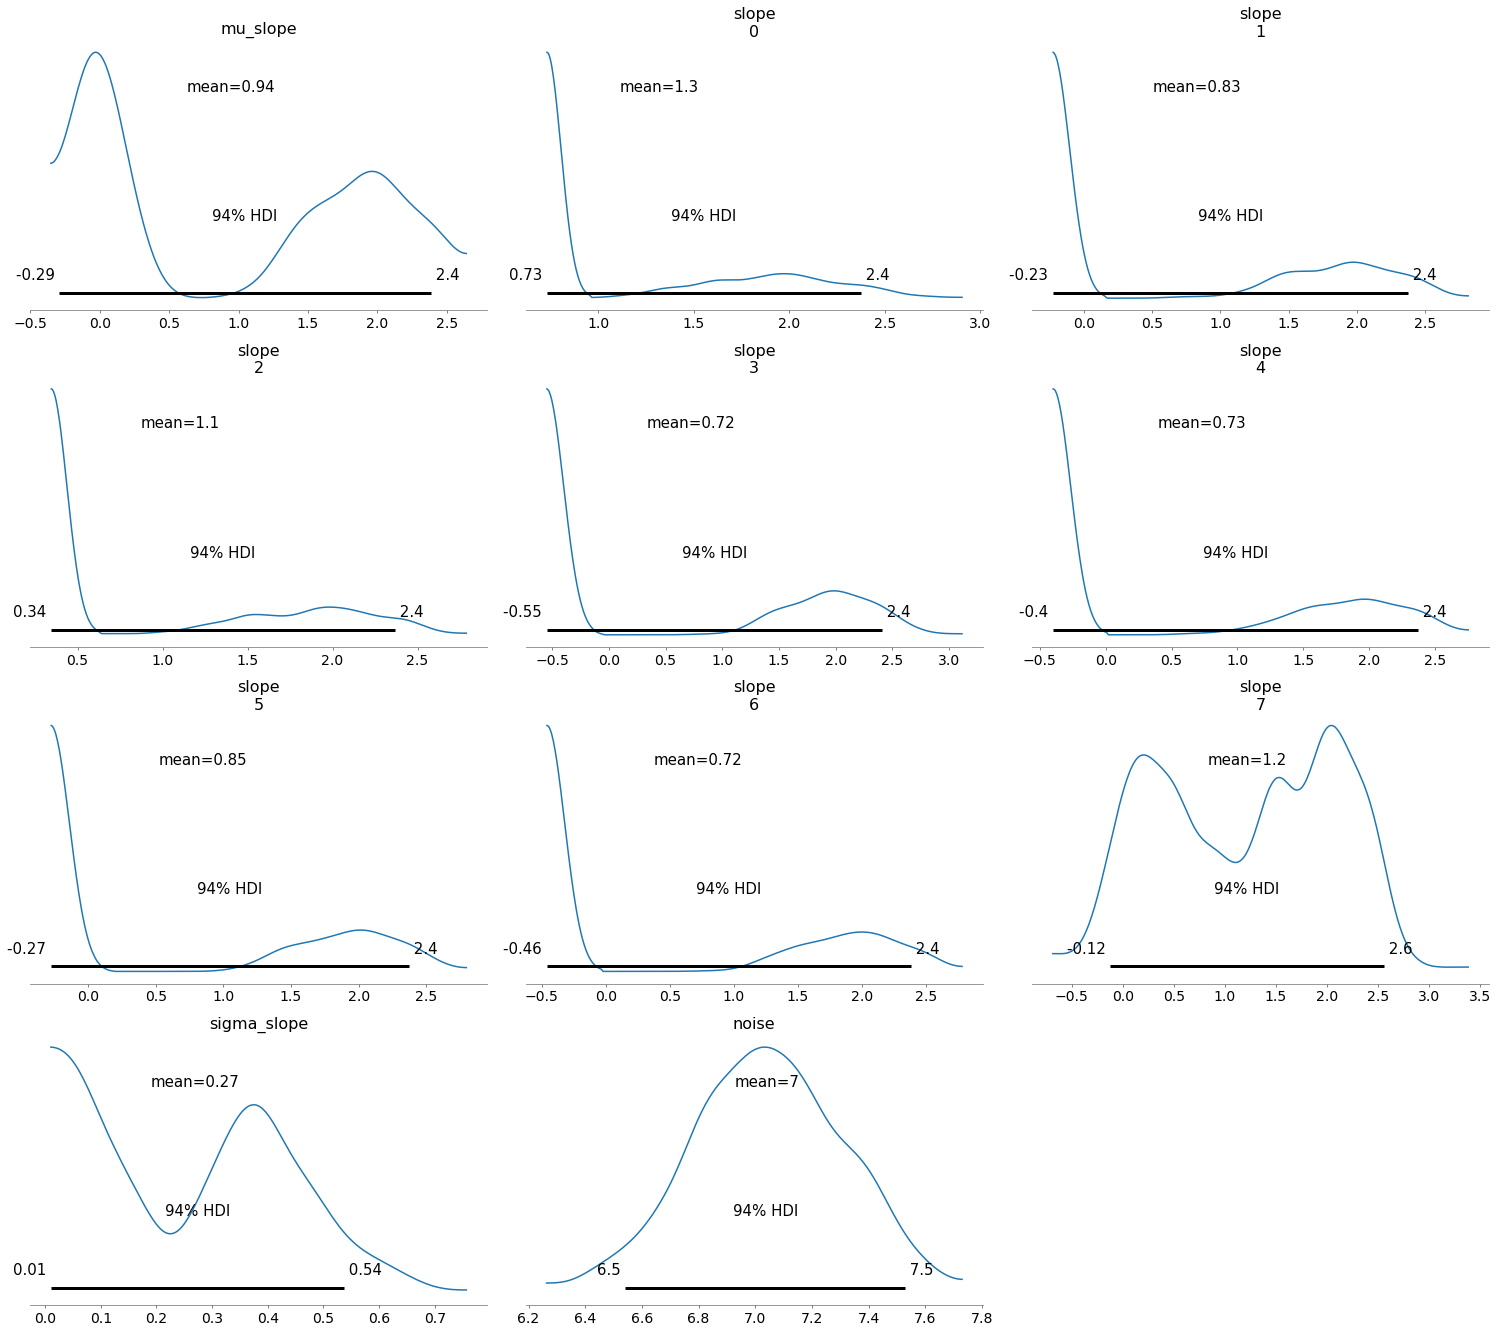

In [90]:
az.plot_posterior(hierarchical_trace)

We still get 8 slopes, and posteriors for our parameters `mu_slope` and `sigma_slope`.

`mu_slope` and `sigma_slope` are called **hyperpriors**, the same way that ANN parameteres are called a **hyperparameters**. 

Both of them are one hierarchy level above `slope[]` as they have to be evaluated ***first*** before `slope[]` can be calculated.

We added `target_accept=0.995` to the sample method to improve the sampling, because sampling from this nested posterior is not as easy anymore as for the unpooled model.

The HDR for the posteriors are:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B0DB6E99B0>],
      dtype=object)

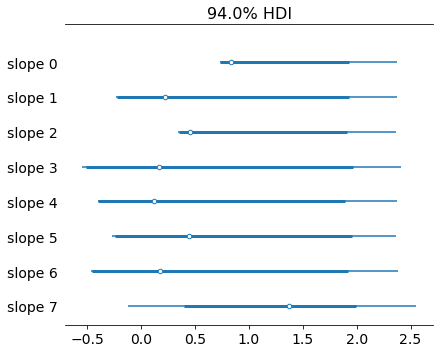

In [91]:
az.plot_forest(hierarchical_trace, var_names=['slope'], combined=True)

Note that the predicted valye of `slope 7` is *much* closer to the true value (my simulation above seems to shrink `slope7` by a bit too much, I don't know why...)! 

That is because the model also tries to figure out the slope mean using the `mu_slope` hyperprior. The true prior should be 2, however, due to the outliers, the model believes that it is about 1.6.

The large slope of fifteen that we have seen in the unpooled model posterior for group 7 gets pulled towards this mu_slope of around 1.6 and ends up at 10. This is also true for the other parameters: For example, slop 6 is smaller.

>**Note**: In hierarchical modeling, all parameters are being pulled towards a global mean. This effect is known as **shrinkage**.

Shrinkage is a rational implication of hierarchical model structure, and is (usually) desired by the data analyst (you) because the shrunken parameter estimates are less affected by random sampling noise than estimates derived without hierarchical structure. 

Intuitively, shrinkage occurs because the estimate of each low-level parameter is influenced from two sources: (1) the subset of data that are directly dependent on the low-level parameter, and (2) the higher-level parameters (or hyperpriors) on which the low-level parameter depends. The higher- level parameters are affected by all the data, and therefore the estimate of a low-level parameter is affected indirectly by all the data, via their influence on the higher-level parameters.

Let's compare the three models visually using the **plate notation**: A visual representation of our models.

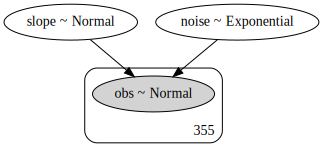

In [92]:
pm.model_to_graphviz(pooled_model)

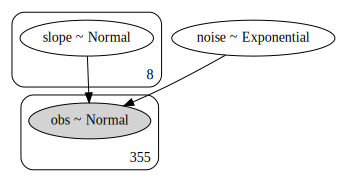

In [93]:
pm.model_to_graphviz(unpooled_model)

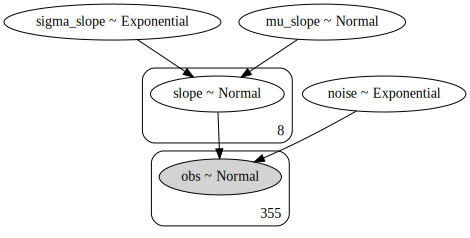

In [94]:
pm.model_to_graphviz(hierarchical_model)

# Conclusion
**Hierarchical modeling** is a generalization of **unpooled modeling**. 

If you set the **hyperpriors** to some ***constant*** random variables, you end up with the unpooled approach again. Otherwise, the hierarchical model does something different by keeping track of **global parameters** such as `mu_slope`, which serves as the seed for the actual parameters we want to estimate. 

Say you have a data likelihood (for a certain distribution) that is a Poisson distribution, with an **Expectation** parameter that is an additive function of two other parameters, which themselves are normal distributions. This allows us to **shrink** the final expectations around a common mean. Otherwise, our expecations would be too random and our simulations would not appear realistic.

>**Note**: Hierarchical modeling is a frequent feature of Sport Models.

Employ hierarchical modeling whenever you can instead of the unpooled approach. The only thing that can go wrong when using hierarchical modeling instead of unpooled modeling is that there are more parameters to estimate, and estimation becomes harder because of the nested parameters.

If problems arise, you can use tricks like changing the MCMC sampling parameters or introducing so-called **non-centered variables**: Such as ` a + b*pm.Normal('X', 0, 1)` instead of `pm.Normal('X', a, b)`.